<a href="https://colab.research.google.com/github/pritika-vig/modeling-adrs/blob/main/feature_engineering/generate_prescriptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q google-cloud-bigquery scikit-learn pandas


In [ ]:
from google.colab import auth, drive
from google.cloud import bigquery
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel



In [ ]:
ADR_ICD9_CODES = set([
    # Original ADR-related codes
    '9950',   # Other anaphylactic reaction
    '9952',   # Unspecified adverse effect of drug, medicinal and biological substance
    'E850',   # Accidental poisoning by analgesics, antipyretics, and antirheumatics
    'E851',   # Accidental poisoning by barbiturates
    'E852',   # Accidental poisoning by other sedatives and hypnotics
    'E853',   # Accidental poisoning by tranquilizers
    'E854',   # Accidental poisoning by other psychotropic agents
    'E855',   # Accidental poisoning by anticonvulsants and anti-Parkinson drugs
    'E856',   # Accidental poisoning by antibiotics
    'E858',   # Accidental poisoning by other drugs
    'E859',   # Accidental poisoning by unspecified drugs
    'E930',   # Adverse effects of antibiotics
    'E931',   # Adverse effects of anti-infectives and antiparasitics
    'E932',   # Adverse effects of hormones and synthetic substitutes
    'E933',   # Adverse effects of primarily systemic agents
    'E934',   # Adverse effects of agents affecting blood constituents
    'E935',   # Adverse effects of analgesics, antipyretics, and antirheumatics
    'E936',   # Adverse effects of anticonvulsants and sedatives
    'E937',   # Adverse effects of psychotropic agents
    'E938',   # Adverse effects of cardiovascular drugs
    'E939',   # Adverse effects of gastrointestinal drugs
    'E940',   # Adverse effects of water, mineral, and uric acid metabolism drugs
    'E941',   # Adverse effects of hormones and synthetic substitutes
    'E942',   # Adverse effects of topical agents
    'E943',   # Adverse effects of ophthalmic drugs
    'E944',   # Adverse effects of otorhinolaryngological drugs
    'E945',   # Adverse effects of anesthetics and therapeutic gases
    'E946',   # Adverse effects of other central nervous system depressants
    'E947',   # Adverse effects of central nervous system stimulants
    'E948',   # Adverse effects of agents primarily affecting the autonomic nervous system
    'E949',   # Adverse effects of other and unspecified drugs and medicines

    # Additional 995.x series (non-food related allergic/anaphylactic responses)
    '9950',   # Other anaphylactic reaction
    '9952',   # Unspecified adverse effect of drug, medicinal and biological substance
    '9954',   # Shock due to anesthesia
    '9956',   # Anaphylactic reaction, unspecified

    # Other drug-induced conditions
    '27669',  # Other fluid and electrolyte disorders (includes drug-induced hyponatremia)
    '36255',  # Toxic maculopathy (e.g., chloroquine toxicity)
    '6923',   # Contact dermatitis due to drugs and medicines in contact with skin
    '6930',   # Dermatitis due to drugs taken internally
    '7080',   # Allergic urticaria (can be drug-related)

])

In [ ]:
auth.authenticate_user()
client = bigquery.Client(project="mit-mlhc-class-450518")  # Replace with your project ID


In [ ]:
# Step 1: Get ICU stays >= 4 days
query = """
SELECT icustay_id, subject_id, hadm_id
FROM `physionet-data.mimiciii_clinical.icustays`
WHERE los >= 4
"""
icu_stays = client.query(query).to_dataframe()

In [ ]:
adr_codes_str = ', '.join([f"'{code}'" for code in ADR_ICD9_CODES])
query = f"""
SELECT DISTINCT icustay_id
FROM `physionet-data.mimiciii_clinical.diagnoses_icd` d
JOIN `physionet-data.mimiciii_clinical.icustays` i ON d.hadm_id = i.hadm_id
WHERE d.icd9_code IN ({adr_codes_str})
"""
adrs = client.query(query).to_dataframe()
adr_icu_ids = set(adrs['icustay_id'])

In [ ]:
icu_ids_str = ', '.join(map(str, icu_stays['icustay_id'].tolist()))
query = f"""
SELECT icustay_id, drug
FROM `physionet-data.mimiciii_clinical.prescriptions`
WHERE icustay_id IN ({icu_ids_str})
"""
prescriptions = client.query(query).to_dataframe()


In [ ]:
print(icu_stays.shape)
print(adrs.shape)
print(prescriptions.shape)

(17277, 3)
(1151, 1)
(1467803, 2)


In [ ]:
# Step 4: Aggregate drug list per ICU stay
icu_drugs = prescriptions.groupby('icustay_id')['drug'].apply(set).reset_index()


In [ ]:
# Step 5: One-hot encode drugs
mlb = MultiLabelBinarizer()
drug_features = mlb.fit_transform(icu_drugs['drug'])
feature_df = pd.DataFrame(drug_features, columns=mlb.classes_)
feature_df.insert(0, 'icustay_id', icu_drugs['icustay_id'])


In [ ]:
drug_data = feature_df.copy()
drug_data['adr'] = drug_data['icustay_id'].apply(lambda x: 1 if x in adr_icu_ids else 0)


In [ ]:
X = drug_data.drop(columns=['icustay_id', 'adr'])
y = drug_data['adr']
svc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000)
svc.fit(X, y)
model = SelectFromModel(svc, prefit=True)
X_reduced = model.transform(X)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
selected_features = X.columns[model.get_support()]
# Convert to DataFrame and add icustay_id
X_reduced_df = pd.DataFrame(X_reduced, columns=selected_features)
X_reduced_df['icustay_id'] = drug_data['icustay_id'].values
cols = ['icustay_id'] + list(selected_features)
X_reduced_df = X_reduced_df[cols]

In [ ]:
print(drug_data['adr'].value_counts())

adr
0    14960
1      483
Name: count, dtype: int64


In [ ]:
drive.mount('/content/drive')
output_path = '/content/drive/My Drive/physionet/prescriptions.csv'
X_reduced_df.to_csv(output_path, index=False)
print(f"Saved processed dataset to: {output_path}")

Mounted at /content/drive
Saved processed dataset to: /content/drive/My Drive/physionet/prescriptions.csv


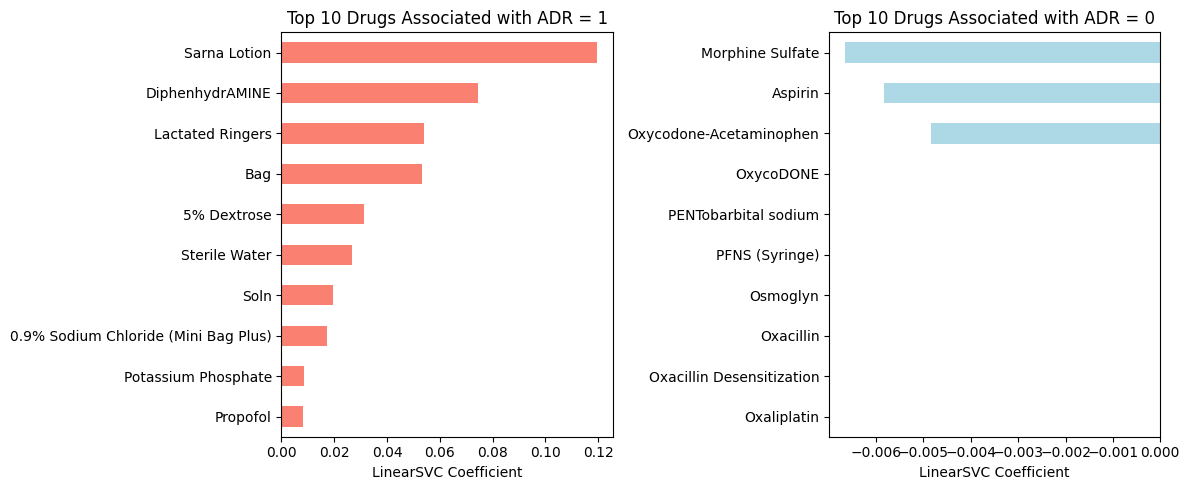

In [ ]:
# Step 10: Plot top 10 features by class association
coef_series = pd.Series(svc.coef_[0], index=X.columns)
import matplotlib.pyplot as plt
# Top features for ADR = 1
top_adr1 = coef_series.sort_values(ascending=False).head(10)
top_adr0 = coef_series.sort_values().head(10)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
top_adr1.plot(kind='barh', title='Top 10 Drugs Associated with ADR = 1', color='salmon')
plt.xlabel('LinearSVC Coefficient')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
top_adr0.plot(kind='barh', title='Top 10 Drugs Associated with ADR = 0', color='lightblue')
plt.xlabel('LinearSVC Coefficient')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'head'